In [24]:
import torch
from torch import nn
import matplotlib.pyplot as plt
 
torch.__version__

'2.4.1+cpu'

In [25]:
weight = 0.7
bias = 0.3 

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(1)
y = weight * X + bias
 
 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [26]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

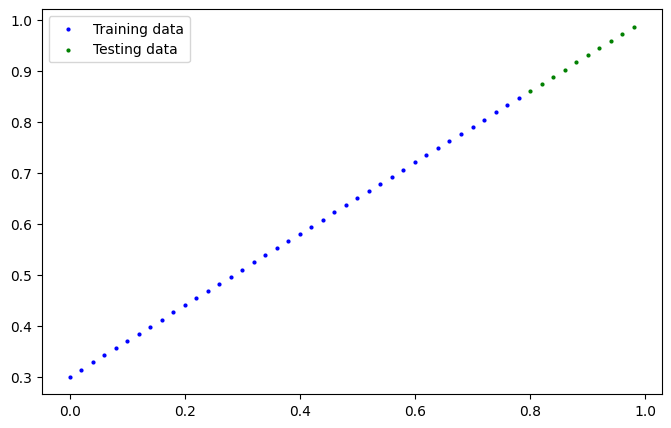

In [27]:
def plot_predictions(train_data=X_train,
                     train_lebels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None
                     ):
    plt.figure(figsize=(8,5))
    
    plt.scatter(train_data, train_lebels, c="b", s=4, label="Training data")
    
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 10})
    
plot_predictions();

In [28]:
class MyLinearRegression(nn.Module): 
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                               dtype=torch.float),
                                   requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype=torch.float),
                                 requires_grad=True)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [29]:
torch.manual_seed(42)

model_0 = MyLinearRegression()

list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)],
 OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]))

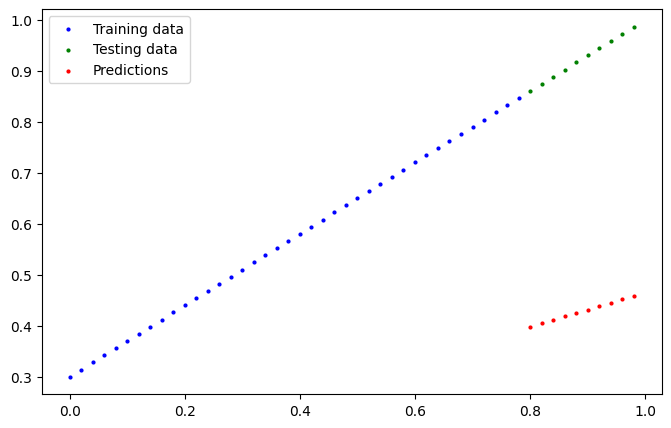

In [30]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

plot_predictions(predictions=y_preds)

In [31]:
# Train model

torch.manual_seed(42)

loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()
    
    y_pred = model_0(X_train)
    
    loss = loss_fn(y_pred, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()    

    optimizer.step()
    
    model_0.eval()    
    with torch.inference_mode():
        test_pred = model_0(X_test)
        
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        
        if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")
    

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495


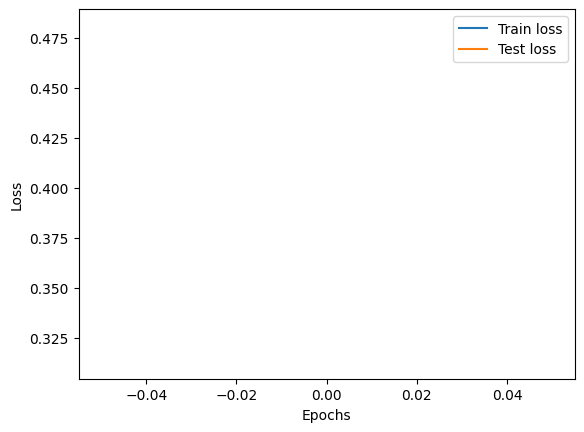

In [32]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

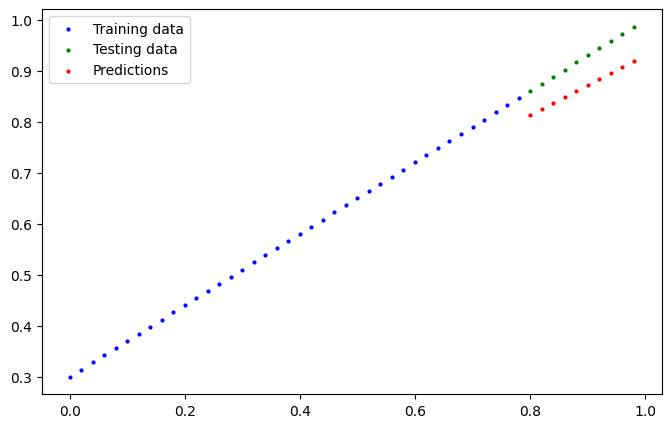

In [33]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds
plot_predictions(predictions=y_preds)

In [34]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [35]:
loaded_model_0 = MyLinearRegression()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.state_dict()

C:\Users\canh\AppData\Local\Temp\ipykernel_13176\1401138634.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [44]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])